# Homework 3

## Question 1

#### Consider the following table which details the use of contraception by age of currently married women in El Salvador in 1985.

<table>
  <tr>
    <th></th>
    <th colspan="3">Contraceptive Method</th>
  </tr>
  <tr>
    <td><b>Age</b></td>
    <td><b>Ster.</b></td>
    <td><b>Other</b></td>
    <td><b>None</b></td>
  </tr>
  <tr>
    <td>15 - 19</td>
    <td>3</td>
    <td>61</td>
    <td>232</td>
  </tr>
  <tr>
    <td>20 - 24</td>
    <td>80</td>
    <td>137</td>
    <td>400</td>
  </tr>
  <tr>
    <td>25 - 29</td>
    <td>216</td>
    <td>131</td>
    <td>301</td>
  </tr>
  <tr>
    <td>30 - 34</td>
    <td>268</td>
    <td>76</td>
    <td>203</td>
  </tr>
  <tr>
    <td>35 - 39</td>
    <td>197</td>
    <td>50</td>
    <td>188</td>
  </tr>
  <tr>
    <td>40 - 44</td>
    <td>150</td>
    <td>24</td>
    <td>164</td>
  </tr>
  <tr>
    <td>45 - 49</td>
    <td>91</td>
    <td>10</td>
    <td>183</td>
  </tr>
</table>

#### Let $ t_{i} $ denote an indicator variable which takes on values $ \{1,2,3\} $ where 1 is Sterilization, 2 is Other, and 3 is None. Consider the activation function:

$$ a_{ij}=\alpha_{j}+\beta_{j}x_{i}+\gamma_{j}x_{i}^{2} $$

#### where $ x_{i} $ is the mid-point of the $ i $-th age group, and $ j \in \{1,2,3\} $. Recall that the multinomial logit model is given by

$$ p\left(t_{i}=j|x_{i}\right)=\frac{exp\left(a_{ij}\right)}{\sum_{j'}exp\left(a_{ij'}\right)} $$

#### Implement multinomial logistic regression from scratch (for the underlying optimization you may use modules such as the ones available in $ \displaystyle{scipy} $) and apply it to the given data. Comment on your observations.

In [145]:
from scipy import optimize
import numpy as np

x = [17, 22, 27, 32, 37, 42, 47]

y = np.matrix([[  3,  62, 232],
               [ 80, 137, 400],
               [216, 131, 301],
               [268,  76, 203],
               [197,  50, 188],
               [150,  24, 164],
               [ 91,  10, 183]])

def xik(i, k):
    return x[i - 1]**k

def betakj(beta, k, j):
    beta_m = np.matrix(beta.reshape((3, 2)))
    return beta_m[k, j - 1]

def aij(beta, i, j):
    sm = 0
    for k in range(3):
        sm += xik(i, k) * betakj(beta, k, j)
    return np.longfloat(sm)

def yij(i, j):
    return y[i - 1, j - 1]

def ni(i):
    return y.sum(axis=1)[i - 1, 0]

def dpii(beta, i):
    sm = 0
    for j in range(1, 3):
        sm += np.exp(aij(beta, i, j))
    return 1 + sm

def likelihood(beta):
    sm = 0
    for i in range(1, 8):
        pii = ni(i) * np.log(dpii(beta, i))
        
        for j in range(1, 3):
            sm += yij(i, j) * aij(beta, i, j) - pii

    return sm

def neg_likelihood(beta):
    return -1.0 * likelihood(beta)
    
def gradient(beta, k, j):
    sm = 0
    for i in range(1, 8):
        sm += yij(i, j) * xik(i, k) - ni(i) * (np.exp(aij(beta, i, j)) / dpii(beta, i)) * xik(i, k)
    return -sm

def neg_likelihood_der(beta):
    der = np.zeros_like(beta)
    idx = 0
    for k in range(3):
        for j in range(1, 3):
            der[idx] = gradient(beta, k, j)
            idx += 1
    return der

def piij(beta, i, j):
    return np.exp(aij(beta, i, j)) / dpii(beta, i)

def hess(beta, k, j, kk, jj):
    sm = 0
    for i in range(1, 8):
        c_piij = piij(beta, i, j)
        if jj == j:
            diff = 1 - c_piij
        else:
            diff = - piij(beta, i, jj)
        sm += ni(i) * xik(i, k) * c_piij * diff * xik(i, kk)
    return sm

def neg_likelihood_hess(beta):
    H = np.zeros((6, 6))
    idx = 0
    jdx = 0
    for k in range(3):
        for j in range(1, 3):
            for kk in range(3):
                for jj in range(1, 3):
                    H[idx, jdx] = hess(beta, k, j, kk, jj)
                    
                    if jdx == 5:
                        jdx = 0
                        idx += 1
                    else:
                        jdx += 1
    return H
                    

beta0 = np.array([-12.62, -4.552, 0.7097, 0.2641, -0.009733, -0.004758])
# res = optimize.minimize(neg_likelihood, beta0, method='Powell')
# res = optimize.fmin_tnc(neg_likelihood, beta0, approx_grad=True)

res = optimize.minimize(neg_likelihood, beta0, method='Newton-CG',
                        jac=neg_likelihood_der, hess=neg_likelihood_hess,
                        options={'eps': 1, 'xtol': 1e-5, 'disp': True})
print(res)

Optimization terminated successfully.
         Current function value: 4962.658655
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1
     fun: 4962.658655031928
     jac: array([ -2.06262218e+01,   6.15506631e+00,  -3.66748822e+02,
         2.57478145e+02,  -2.26296577e+03,   9.85941062e+03])
 message: 'Optimization terminated successfully.'
    nfev: 2
    nhev: 1
     nit: 1
    njev: 2
  status: 0
 success: True
       x: array([ -1.26199999e+01,  -4.55200001e+00,   7.09701172e-01,
         2.64099308e-01,  -9.73534194e-03,  -4.78596090e-03])


Now we try to show the $ p\left(t_{i}=j|x_{i}\right) $ for each category of each age group.

In [146]:
beta_ml = np.array([-1.26199999e+01,  -4.55200001e+00,   7.09701172e-01,
         2.64099308e-01,  -9.73534194e-03,  -4.78596090e-03])

for i in range(1, 8):
    prob = {}
    for j in range(1, 3):
        prob[j] = piij(beta_ml, i, j)
    prob[3] = 1- prob[1] - prob[2]
    
    for j in range(1, 4):
        print(str(i) + "-th age group, " + str(j) + " category -> " + str(prob[j]))

1-th age group, 1 category -> 0.0271149154252
1-th age group, 2 category -> 0.185531241143
1-th age group, 3 category -> 0.787353843432
2-th age group, 1 category -> 0.117490335238
2-th age group, 2 category -> 0.227378352767
2-th age group, 3 category -> 0.655131311994
3-th age group, 1 category -> 0.290424222167
3-th age group, 2 category -> 0.203606870521
3-th age group, 3 category -> 0.505968907312
4-th age group, 1 category -> 0.452302533627
4-th age group, 2 category -> 0.147121342444
4-th age group, 3 category -> 0.400576123929
5-th age group, 1 category -> 0.51926132446
5-th age group, 2 category -> 0.100367739664
5-th age group, 3 category -> 0.380370935876
6-th age group, 1 category -> 0.468843836967
6-th age group, 2 category -> 0.0689719223515
6-th age group, 3 category -> 0.462184240681
7-th age group, 1 category -> 0.302855447184
7-th age group, 2 category -> 0.0434300074912
7-th age group, 3 category -> 0.653714545325


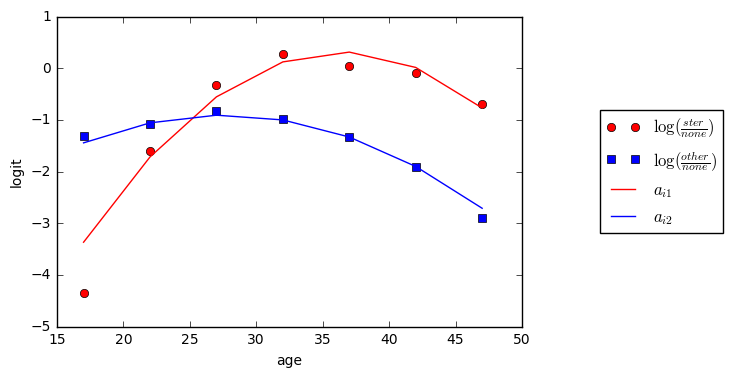

In [147]:
import matplotlib.pyplot as plt

odds_ster = []
odds_other = []
logit_ster = []
logit_other = []

for i in range(1, 8):
    odds_ster.append(np.log(y[i - 1, 0] * 1.0 / y[i - 1, 2]))
    odds_other.append(np.log(y[i - 1, 1] * 1.0 / y[i - 1, 2]))
    
    logit_ster.append(aij(beta_ml, i, 1))
    logit_other.append(aij(beta_ml, i, 2))
    

plt.plot(x, odds_ster, 'ro', color='red', label=r'$\log(\frac{ster}{none})$')
plt.plot(x, other_ster, 'bs', color='blue', label=r'$\log(\frac{other}{none})$')
plt.plot(x, logit_ster, color='red', label=r'$a_{i1}$')
plt.plot(x, logit_other, color='blue', label=r'$a_{i2}$')

plt.xlabel('age')
plt.ylabel('logit')

plt.legend(loc='center', bbox_to_anchor=(1.3, 0.5))

## Question 2

#### Download the Enron-spam dataset from http://www.aueb.gr/users/ion/data/enron-spam/. Use the pre-processed datasets Enron1, . . . , Enron5 as training data and Enron6 as test data.

**Implement the Naive Bayes algorithm that we discussed in the class (a good in-depth reference is http://nlp.stanford.edu/IR-book/pdf/13bayes.pdf). Remember to perform all calculations on the log scale to prevent underow.**

- ** Report the accuracy on the test set.**

- **How do you account for dierent prior probabilities for spam and ham?**

- **Does the performance of the classier change when you do add one Laplace smoothing?**

- **What are the most discriminative words as per the naive Bayes classifer?**

We first extract all messages from archives.

In [149]:
import tarfile
import glob

WORKDIR = 'workdir'

In [150]:
def msg_dir(members):
    for tarinfo in members:
        if (tarinfo.name.count('/') > 1):
            yield tarinfo

for file in glob.glob("Enron-Spam/*.tar.gz"):
    print("Extracting " + file)
    with tarfile.open(file, 'r:gz') as tar:
        tar.extractall(path=WORKDIR, members=msg_dir(tar))

Extracting Enron-Spam/enron6.tar.gz
Extracting Enron-Spam/enron5.tar.gz
Extracting Enron-Spam/enron2.tar.gz
Extracting Enron-Spam/enron1.tar.gz
Extracting Enron-Spam/enron4.tar.gz
Extracting Enron-Spam/enron3.tar.gz


Then, start to train the Naive Bayes classifier.

> 1) Define a function which strip meaningless words, which includes punctuation mark and stopwords. We get the "Default English stopwords" from http://www.ranks.nl/stopwords

In [151]:
from string import punctuation
import re

punc_regex = re.compile('[%s]' % re.escape(punctuation.replace("'", "")))
apos_regex = re.compile('(\w)\s\'\s(\w)')

STOPWORDS_FILENAME = 'stopwords.txt'
with open(STOPWORDS_FILENAME, 'r') as f:
    stopwords = set(f.read().splitlines())

# strip meaningless words from a string and return a
# meaningful list of words.
def strip_meaningless(s):
    # replace any punctuation marks but the apostrophe with space
    clean_s = punc_regex.sub(' ', s)
    
    # format case "what ' s" to "what's" in order to capture the stopwrods like "that's"
    clean_s = apos_regex.sub('\\1\'\\2', clean_s)
    
    c_l = [word.lower() for word in clean_s.split()]
    return [word for word in c_l if word not in stopwords]

>  2) Extract all vocabulary and count the number of message in class ham and spam, respectively, in this round.

In [152]:
num_hams = 0
num_spams = 0

words_ham = []
words_spam = []

FILE_ENCODING = 'ISO-8859-1'

# As the question mentioned, use the pre-processed datasets
# Enron1, ..., Enron5 as training data and Enron6 as test data.
for file in glob.glob(WORKDIR + '/enron[1-5]/*/*.txt'):
    is_ham = file.endswith('ham.txt')
    if is_ham:
        num_hams += 1
    else:
        num_spams += 1

    with open(file, 'r', encoding=FILE_ENCODING) as f_msg:
        content = strip_meaningless(f_msg.read())
        
        if is_ham:
            words_ham.extend(content)
        else:
            words_spam.extend(content)

vocabulary = set(words_ham + words_spam)
vocabulary.remove("'")    # we think the apostrophe should not be one of word in vocabulary

> Save all the vocabulary to vocabulary.txt if you want to have a look.

In [153]:
with open('out/vocabulary.txt', mode='w', encoding=FILE_ENCODING) as voc_file:
    voc_file.write('\n'.join(vocabulary))

> 3) Compute $ \hat{P}\left(c\right) $ and all $ \hat{P}\left(t_{k}|c\right) $

In [154]:
import operator

prior_ham = num_hams * 1.0 / (num_hams + num_spams)
prior_spam = num_spams * 1.0 / (num_hams + num_spams)

print("Prior probabilities for ham: " + str(prior_ham))
print("Prior probabilities for spam: " + str(prior_spam))

words_ham_count = {}
for word in words_ham:
    if word in words_ham_count:
        words_ham_count[word] += 1
    else:
        words_ham_count[word] = 1

words_spam_count = {}
for word in words_spam:
    if word in words_spam_count:
        words_spam_count[word] += 1
    else:
        words_spam_count[word] = 1

condprob_ham = {}
condprob_spam = {}

for word in vocabulary:
    condprob_ham[word] = (words_ham_count.get(word, 0) + 1) * 1.0 / (len(words_ham) + len(vocabulary))
    condprob_spam[word] = (words_spam_count.get(word, 0) + 1) * 1.0 / (len(words_spam) + len(vocabulary))
    
    # without Laplace smoothing
#     condprob_ham[word] = words_ham_count.get(word, 0) * 1.0 / len(words_ham)
#     condprob_spam[word] = words_spam_count.get(word, 0) * 1.0 / len(words_spam)

# sort condprob_ham and condprob_spam by values
sorted_condprob_ham = sorted(condprob_ham.items(), key=operator.itemgetter(1))
sorted_condprob_spam = sorted(condprob_spam.items(), key=operator.itemgetter(1))

print("The most discriminative words in condprob_ham: " + str(sorted_condprob_ham[-1]))
print("The most discriminative words in condprob_spam: " + str(sorted_condprob_spam[-1]))

Prior probabilities for ham: 0.5428272477991052
Prior probabilities for spam: 0.4571727522008948
The most discriminative words in condprob_ham: ('enron', 0.016913688602462673)
The most discriminative words in condprob_spam: ('subject', 0.007590890505477282)


> 4) Now we can apply this Naive Bayes classifier to do prediction.

In [164]:
import numpy as np

corrects  = 0
num_test_msgs = 0

most_disc_of_file = {}

for file in glob.glob(WORKDIR + '/enron6/*/*.txt'):
    is_true_ham = file.endswith('ham.txt')
    
    most_disc = ('', '', 0)
    
    with open(file, 'r', encoding=FILE_ENCODING) as f_msg:
        content = strip_meaningless(f_msg.read())
        
        score_ham = np.log(prior_ham)
        score_spam = np.log(prior_spam)
        for word in content:
            if word in vocabulary:    # ignore word if it's not in the vocabulary
                prob_in_ham = condprob_ham[word]
                prob_in_spam = condprob_spam[word]
                
                if prob_in_ham >= most_disc[2]:
                    most_disc = (word, 'ham', prob_in_ham)
                
                if prob_in_spam >= most_disc[2]:
                    most_disc = (word, 'spam', prob_in_spam)
                
                score_ham += np.log(prob_in_ham)
                score_spam += np.log(prob_in_spam)
        
        most_disc_of_file[file] = most_disc
            
        num_test_msgs += 1
        
        if ((score_ham > score_spam) and is_true_ham) or ((score_ham < score_spam) and not is_true_ham):
            corrects += 1

print("The accuracy on the test set is: " + str(corrects  * 1.0 / num_test_msgs))

with open('out/most_disc_of_file.txt', mode='w', encoding=FILE_ENCODING) as f:
    for key, value in most_disc_of_file.items():
        f.write(key + ': (' + value[0] + ', ' + value[1] + ', ' + str(value[2]) + ')\n')

The accuracy on the test set is: 0.9818333333333333


Finally, we clean all temporary files.

In [8]:
import shutil

shutil.rmtree(WORKDIR)

# Question 3

#### Work on the same dataset as the above problem.

- **Implement the binary logistic regression algorithm that we discussed in the class. You may use any optimizer of your choice including optimization modules from $ \displaystyle{scipy} $.**
 - **Report accuracy on test set.**
 - **How do you account for different prior probabilities for spam and ham?**
 - **What are the most discriminative words as per the logistic regression classifer?**

- **Implement the Bayesian logistic regression algorithm that we discussed in the class.**
 - **Report accuracy on test set.**
 - **How does the accuracy change when the strength of the prior changes?**

#### Comment on the differences and similarities between the three classifers that you implemented to solve the spam detection problem (naive bayes, binary logistic regression and bayesian logistic regression)?

### binary logistic regression algorithm